In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

%matplotlib inline

### Загрузка, обзор данных

In [2]:
data_train = pd.read_csv('./data/train-kaggle.csv')
data_test = pd.read_csv('./data/test-kaggle.csv')

In [3]:
def save_prepared_data(df, name):
    df.to_csv(f'./data/prepared_{name}.csv', index=False)

In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 18 columns):
Id                              7500 non-null int64
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    594

**Глобальные переменные**

In [5]:
home_own = 'Home Ownership' # домовладение
ann_income = 'Annual Income' # годовой доход
years_on_job = 'Years in current job' # количество лет на текущем месте работы
tax_liens = 'Tax Liens' # налоговые льготы
numb_accounts = 'Number of Open Accounts' # количество открытых счетов
years_cred_hist = 'Years of Credit History' # количество лет кредитной истории
max_credit = 'Maximum Open Credit' # наибольший открытый кредит
cred_problems = 'Number of Credit Problems' # количество проблем с кредитом
months_last_delinq = 'Months since last delinquent' # количество месяцев с последней просрочки платежа
bancrupcies = 'Bankruptcies' # банкротства
purpose = 'Purpose' # цель кредита
term = 'Term' # срок кредита
cur_loan_amount = 'Current Loan Amount' # текущая сумма кредита
cur_cred_bal = 'Current Credit Balance' # текущий кредитный баланс
month_debt = 'Monthly Debt' # ежемесячный долг
cred_score = 'Credit Score' # ???
cred_default = 'Credit Default' # факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

**Обзор номинативных признаков**

In [6]:
def print_nominative(df):
    for cat_colname in df.select_dtypes(include='object').columns:
        print(f"\n{cat_colname}:\n\n{df[cat_colname].value_counts()}\n\n{'*'*30}")

print_nominative(data_train)


Home Ownership:

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

******************************

Years in current job:

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

******************************

Purpose:

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

******************************

Term:

Short Term    5556

**Обзор численных признаков**

In [7]:
data_train.describe()

,Id,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7500.000000,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,3749.500000,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,2165.207842,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,0.000000,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,1874.750000,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,3749.500000,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,5624.250000,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,7499.000000,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


### Подготовка данных

**Обработка пропусков**

In [8]:
def print_na(df):
    print(len(df) - df.count())
    
print_na(data_train)

Id                                 0
Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64


In [9]:
def diff(first, second):
    second = set(second)
    return [item for item in first if item not in second]

In [10]:
def fill_annual_income(df):
    df[ann_income] = df[ann_income].fillna(df[ann_income].mean())
    return df

In [11]:
def fill_years_cur_job(df):
    df[years_on_job] = df[years_on_job].fillna(df[years_on_job].mode()[0])
    return df

In [12]:
def fill_months_last_del(df):
    df[months_last_delinq] = df[months_last_delinq].fillna(df[months_last_delinq].mean())
    return df

In [13]:
def fill_bankruptcies(df):
    df[bancrupcies] = df[bancrupcies].fillna(df[bancrupcies].mean())
    return df

In [14]:
def fill_credit_score(df):
    df[cred_score] = df[cred_score].fillna(df[cred_score].mean())
    return df

In [15]:
def fill_na(df):
    df = fill_annual_income(df)
    df = fill_years_cur_job(df)
    df = fill_months_last_del(df)
    df = fill_bankruptcies(df)
    df = fill_credit_score(df)
    return df

**Построение новых признаков**

In [16]:
def set_id(df):
    # df['Id'] = pd.Series(df.index.tolist(), dtype=str)
    return df

In [17]:
def cross_numeric(df):
    cols = diff(df.columns.to_list(), [cred_default])
#     c2 = cred_score
    for c1 in cols:
        for c2 in cols:
            if np.issubdtype(df[c1].dtype, np.number) and np.issubdtype(df[c2].dtype, np.number):
                df[f'{c1}_{c2}'] = df[c1] * df[c2]
    return df

In [18]:
def sqr_numeric(df):
    cols = diff(df.columns.to_list(), [cred_default])
    for c in cols:
        if np.issubdtype(df[c].dtype, np.number):
            df[f'sqr_{c}'] = df[c] * df[c]
#             df[f'third_{c}'] = df[c] * df[c] * df[c]
            df[f'sqrt_{c}'] = df[c]**0.5
    return df

**Dummies**

In [19]:
def dummies(df):
    df['Term_bin'] = df[term].map({'Long Term':'1', 'Short Term':'0'}).astype(int)
    for cat_colname in df.select_dtypes(include='object').columns[1:]:
        df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
    return df

In [20]:
def rename(df):
    for cat_colname in df.columns:
        new_col_name = cat_colname \
            .replace('+', 'more') \
            .replace('>', 'more') \
            .replace('<', 'less')
        if cat_colname != new_col_name:
            df.rename(columns={cat_colname: new_col_name}, inplace=True)
    return df

In [21]:
def prepare_data(df):
    df = df.copy()
    df = fill_na(df)
#     df = cross_numeric(df)
    df = sqr_numeric(df)
    df = dummies(df)
    df = set_id(df)
    df = rename(df)
    return df

In [22]:
train_prepared = prepare_data(data_train)

In [23]:
save_prepared_data(train_prepared, 'train')

In [24]:
train_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 73 columns):
Id                                   7500 non-null int64
Home Ownership                       7500 non-null object
Annual Income                        7500 non-null float64
Years in current job                 7500 non-null object
Tax Liens                            7500 non-null float64
Number of Open Accounts              7500 non-null float64
Years of Credit History              7500 non-null float64
Maximum Open Credit                  7500 non-null float64
Number of Credit Problems            7500 non-null float64
Months since last delinquent         7500 non-null float64
Bankruptcies                         7500 non-null float64
Purpose                              7500 non-null object
Term                                 7500 non-null object
Current Loan Amount                  7500 non-null float64
Current Credit Balance               7500 non-null float64
Monthly Debt  

### Работа с моделью

In [25]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [26]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

**Отбор признаков**

In [27]:
TARGET_NAME = cred_default
BASE_FEATURE_NAMES = data_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = train_prepared.columns.drop([TARGET_NAME, 'Id'] + BASE_FEATURE_NAMES).tolist()

In [28]:
# NUMERIC_FEATURE_NAMES = [ann_income, tax_liens, numb_accounts, years_cred_hist, max_credit, cred_problems, months_last_delinq, bancrupcies, cur_loan_amount, cur_cred_bal, month_debt, cred_score]
numerics = ['int64', 'float64', 'uint8']
newdf = train_prepared.select_dtypes(include=numerics)
NUMERIC_FEATURE_NAMES = newdf.columns.drop([TARGET_NAME]).to_list()

In [29]:
feats_top = [cred_score, cur_loan_amount, ann_income,  max_credit, 'Term_bin', month_debt]
FEATURE_NAMES_SELECTED = list(set(NUMERIC_FEATURE_NAMES + NEW_FEATURE_NAMES))
# FEATURE_NAMES_SELECTED = feats_top

**Нормализация данных**

In [30]:
def normalize(df):
    scaler = StandardScaler()

    df_norm = df.copy()
    df_norm[NUMERIC_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUMERIC_FEATURE_NAMES])

    return df_norm.copy()

In [31]:
train_prepared = normalize(train_prepared)

**Разбиение test и train**

In [32]:
def split(df):
    X = df[FEATURE_NAMES_SELECTED]
    y = df[TARGET_NAME]

    return train_test_split(X, y, shuffle=True, test_size=0.25, random_state=211)

In [33]:
X_train, X_test, y_train, y_test = split(train_prepared)

**Построение и оценка модели**

### CatBoost

**Подбор гиперпараметров**

In [34]:
def best_params():
    model_catb = catb.CatBoostClassifier(silent=True, random_state=21, class_weights=[1, 2.5])
    params = {'n_estimators':[50, 100, 200, 500], 
          'max_depth':[3, 5, 7, 10],
          'learning_rate':[0.001, 0.01, 0.05, 0.1]}
    cv=KFold(n_splits=3, random_state=21, shuffle=True)
    rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
    rs.fit(X_train, y_train)
    
    print(rs.best_score_)
    return rs.best_params_

In [35]:
# %%time

# best_params_ = best_params()
# best_params_ = {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05} # 0.51 0.64 0.57
best_params_ = {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01} # 0.53 0.57 0.55
# best_params_ = {'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.05} # 0.52 0.59 0.55

In [36]:
best_params_

{'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.01}

In [37]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [38]:
model_catb_final = catb.CatBoostClassifier(class_weights=[1, 2.5], silent=True, random_state=21, **best_params_)
model_catb_final.fit(X_train, y_train)

y_train_pred = model_catb_final.predict(X_train)
y_test_pred = model_catb_final.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      4047
           1       0.58      0.63      0.60      1578

    accuracy                           0.77      5625
   macro avg       0.72      0.73      0.72      5625
weighted avg       0.77      0.77      0.77      5625

TEST

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1340
           1       0.53      0.58      0.55       535

    accuracy                           0.74      1875
   macro avg       0.68      0.69      0.68      1875
weighted avg       0.74      0.74      0.74      1875

CONFUSION MATRIX

col_0            0.0  1.0
Credit Default           
0               1070  270
1                226  309


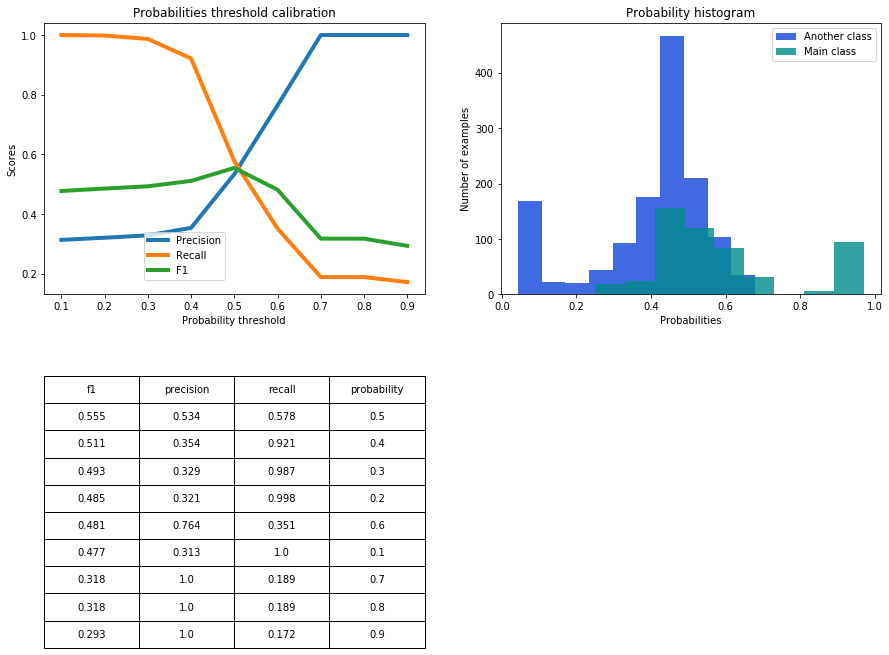

In [39]:
y_test_pred_probs = model_catb_final.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

In [40]:
feat_imp = pd.DataFrame({'feat': model_catb_final.feature_names_, 'importance': model_catb_final.get_feature_importance()})
feat_imp.sort_values('importance', ascending=False).head(10)

,feat,importance
42,sqr_Credit Score,20.098069
52,Credit Score,13.918087
58,sqrt_Credit Score,13.676031
13,sqrt_Current Loan Amount,10.413994
67,sqr_Current Loan Amount,9.557641
0,Current Loan Amount,7.813555
65,sqr_Annual Income,2.913355
55,sqrt_Annual Income,2.355252
62,Annual Income,2.279773
26,Term_Long Term,1.744271


In [41]:
test_prepared = prepare_data(data_test)
for col in diff(train_prepared.columns, test_prepared.columns):
    if col != TARGET_NAME:
        test_prepared[col] = train_prepared[col].mode()[0]
test_prepared = normalize(test_prepared)

In [42]:
predicted = model_catb_final.predict(test_prepared[FEATURE_NAMES_SELECTED])

In [45]:
pred_df = pd.DataFrame({'Id': data_test['Id'], cred_default: pd.Series(predicted, dtype='bool')})

In [44]:
pred_df.to_csv('./data/YZinovev_predictions-kaggle.csv', index=False)